In [1]:
import json
import os
import time
import ipyparallel as ipp

import matplotlib.pyplot as plt
import torch
import dfca as DFCA
import ifca as IFCA

import numpy as np

from util import *

Reads Config file and prepares the arguments you can choose in the config_dfca.json/config_ifca.json

In [2]:
rc = ipp.Cluster(n=3).start_and_connect_sync()
rc.activate()

rc.ids 

dview = rc[:]

Starting 3 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/3 [00:00<?, ?engine/s]

In [ ]:
learning_rates = [0.1]

dfca_li = []
dfca_gi = []
ifca = []

In [ ]:
%%px --targets all

import sys
import os
import random
sys.path.append(os.getcwd())

random.seed(42)
seeds = random.sample(range(10000), 5)
learning_rates = [0.1]

dfca_li = []
dfca_gi = []
ifca = []

Running the dfca-gi experiment

In [5]:
%%px --target 0 --noblock
import dfca as DFCA
import json
import time
import torch
import numpy as np


with open("config_dfca_gi.json", "r") as read_file:
    config = json.load(read_file)

for lr in learning_rates:
    config['lr'] = lr
    res_final = []

    for seed in seeds:
        print(f"---------------------------------DFCA-LI, lr: {lr}, seed: {seed}---------------------------------")
        start_time = time.time()
        config['data_seed'] = seed
        config['train_seed'] = config['data_seed']

        print("config:",config)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {device}")

        exp = DFCA.TrainEMNISTCluster(config, device)
        exp.setup()
        res = exp.run()
        res_final.append([[r['test']['loss'] for r in res], [r['test']['acc'] for r in res], [r['test']['cl_acc'] for r in res]])
        del exp
        duration = (time.time() - start_time)
        print("---train cluster Ended in %0.2f hour (%.3f sec) " % (duration/float(3600), duration))

    res_mean = np.mean(res_final, axis=0).tolist()
    dfca_gi.append(res_mean)



<AsyncResult(%px): pending>

Running the dfca-li experiment


In [6]:
%%px --target 1 --noblock
import dfca as DFCA
import json
import time
import torch
import numpy as np


with open("config_dfca_li.json", "r") as read_file:
    config = json.load(read_file)

for lr in learning_rates:
    config['lr'] = lr
    res_final = []

    for seed in seeds:
        print(f"---------------------------------DFCA-LI, lr: {lr}, seed: {seed}---------------------------------")
        start_time = time.time()
        config['data_seed'] = seed
        config['train_seed'] = config['data_seed']

        print("config:",config)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {device}")

        exp = DFCA.TrainEMNISTCluster(config, device)
        exp.setup()
        res = exp.run()
        res_final.append([[r['test']['loss'] for r in res], [r['test']['acc'] for r in res], [r['test']['cl_acc'] for r in res]])
        del exp
        duration = (time.time() - start_time)
        print("---train cluster Ended in %0.2f hour (%.3f sec) " % (duration/float(3600), duration))

    res_mean = np.mean(res_final, axis=0).tolist()
    dfca_li.append(res_mean)



<AsyncResult(%px): pending>

Running the ifca experiment

In [7]:
%%px --target 2 --noblock
import ifca as IFCA
import json
import time
import torch
import numpy as np

with open("config_ifca.json", "r") as read_file:
    config = json.load(read_file)

for lr in learning_rates:
    config['lr'] = lr
    res_final = []

    for seed in seeds:
        print(f"---------------------------------IFCA, lr: {lr}, seed: {seed}---------------------------------")
        start_time = time.time()
        config['data_seed'] = seed
        config['train_seed'] = config['data_seed']

        print("config:",config)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {device}")

        exp = IFCA.TrainEMNISTCluster(config, device)
        exp.setup()
        res = exp.run()
        res_final.append([[r['test']['loss'] for r in res], [r['test']['acc'] for r in res], [r['test']['cl_acc'] for r in res]])
        del exp
        duration = (time.time() - start_time)
        print("---train cluster Ended in %0.2f hour (%.3f sec) " % (duration/float(3600), duration))

    res_mean = np.mean(res_final, axis=0).tolist()
    ifca.append(res_mean)



<AsyncResult(%px): pending>

Experiment Final Results: 

In [8]:
rc.wait_interactive()
_.display_outputs()
__.display_outputs()
___.display_outputs()

dfca_gi = rc[0].pull('dfca_gi', block=True)
dfca_li = rc[1].pull('dfca_li', block=True)
ifca = rc[2].pull('ifca', block=True)

unknown:   0%|          | 0/3 [00:00<?, ?tasks/s]

---------------------------------IFCA, lr: 0.001, seed: 11---------------------------------
config: {'m': 1200, 'm_test': 200, 'p': 2, 'n': 200, 'uneven': True, 'h1': 128, 'num_epochs': 100, 'batch_size': 100, 'tau': 5, 'lr': 0.001, 'data_seed': 11, 'train_seed': 11, 'config_override': '', 'project_dir': 'output_ifca'}
Using device: cuda
Epoch -1 tr: l 3.848 a 0.024 clct[559, 641] cl_acc 0.546  3.428sec
Epoch -1 tst: l 3.848 a 0.023 clct[85, 115] cl_acc 0.555  0.489sec
Epoch 0 tr: l 3.848 a 0.024 clct[559, 641] cl_acc 0.546  lr 0.001000 11.563sec(train) 3.162sec(infer)
Epoch 0 tst: l 3.848 a 0.024 clct[85, 115] cl_acc 0.555  0.564sec
result written at output_ifca/results.pickle
checkpoint written at output_ifca/checkpoint.pt
Epoch 1 tr: l 3.848 a 0.024 clct[559, 641] cl_acc 0.546  lr 0.001000 9.949sec(train) 4.481sec(infer)
Epoch 1 tst: l 3.848 a 0.024 clct[85, 115] cl_acc 0.555  0.757sec
Epoch 2 tr: l 3.848 a 0.024 clct[559, 641] cl_acc 0.546  lr 0.001000 11.541sec(train) 7.595sec(inf

{'test_loss': [[3.8466805143356324, 3.8466285731792453, 3.84657671713829, 3.846524708986282, 3.8464727263450618, 3.8464209563732146, 3.8463691365718837, 3.8463172066211704, 3.846265274047852, 3.8462134273052215, 3.8461615324020384, 3.846109689950943, 3.84605779504776, 3.846006027936936, 3.8459540431499484, 3.8459021532535553, 3.845850188970566, 3.845798318386078, 3.845746484518051, 3.845694793224335, 3.8456431162357334, 3.845591356992722, 3.8455395097732543, 3.845487872362137, 3.8454362413883203, 3.8453847084045414, 3.845333122014999, 3.84528170132637, 3.845230309009552, 3.84517893409729, 3.845127708435059, 3.8450764741897587, 3.845025235652924, 3.8449741265773776, 3.844923030614853, 3.8448717508316044, 3.8448204882144927, 3.8447693274021146, 3.8447181241512296, 3.8446667044162752, 3.844615304708481, 3.8445640361309055, 3.8445127842426303, 3.8444613790512085, 3.8444099893569947, 3.8443586792945865, 3.8443073828220364, 3.844256089448929, 3.84420462012291, 3.8441530759334563, 3.844101815

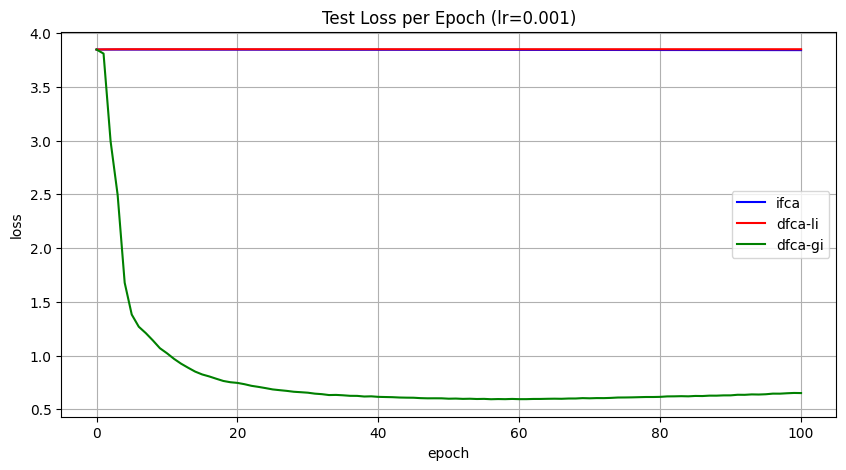

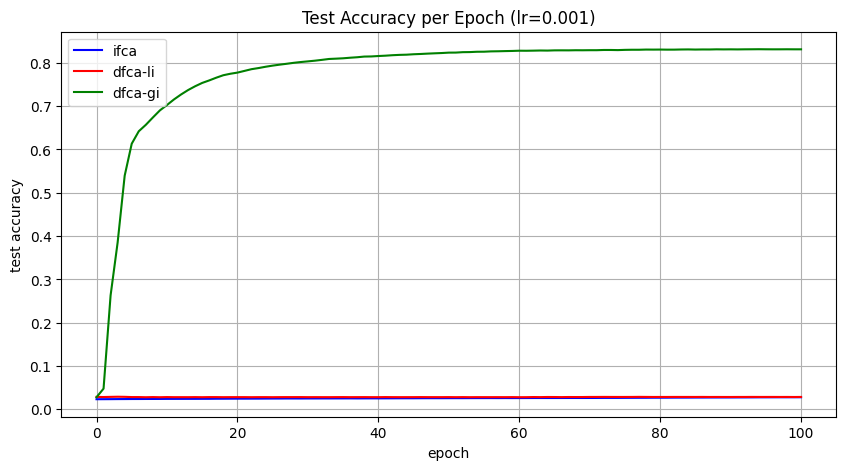

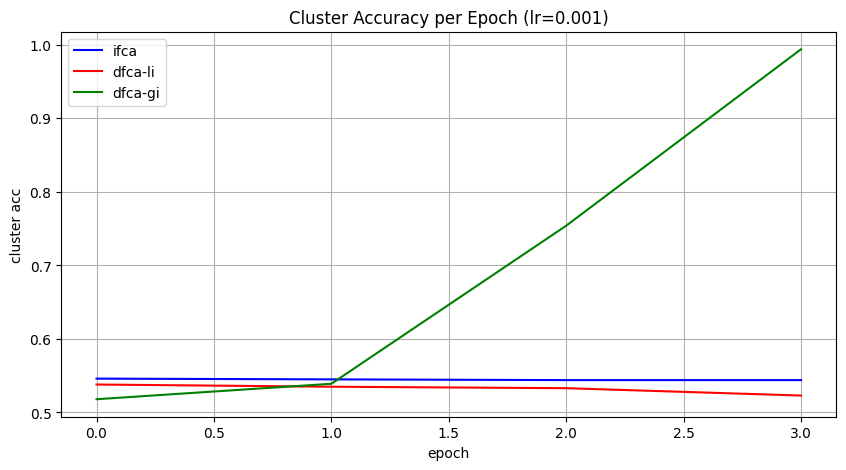

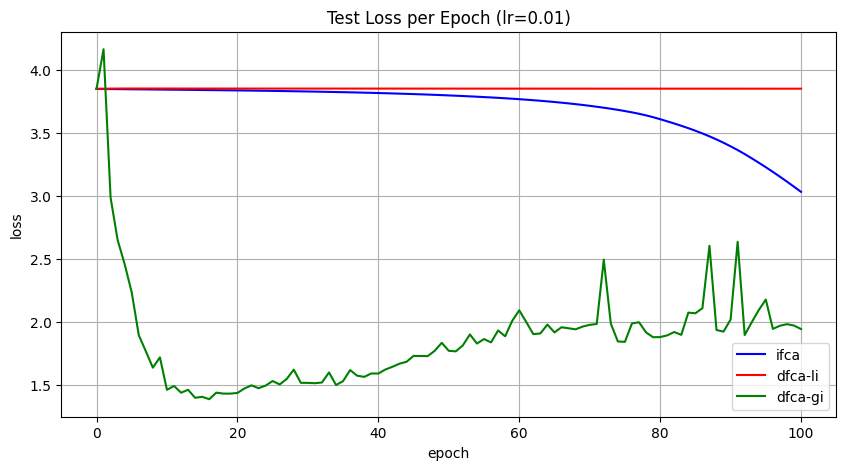

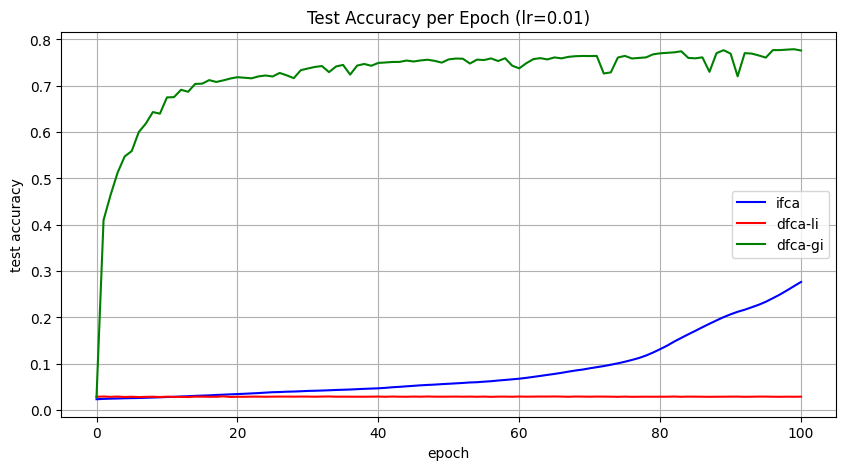

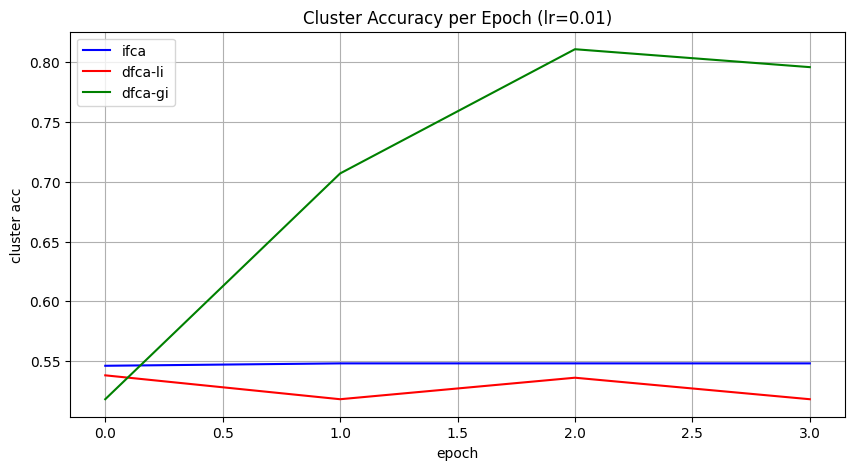

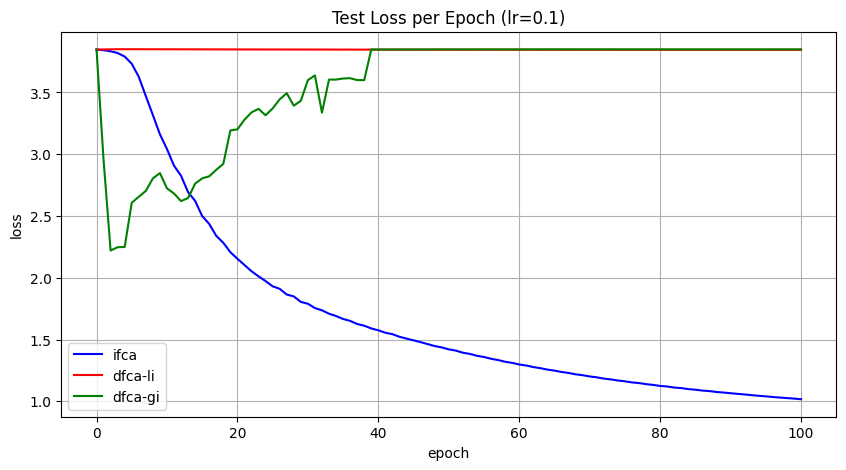

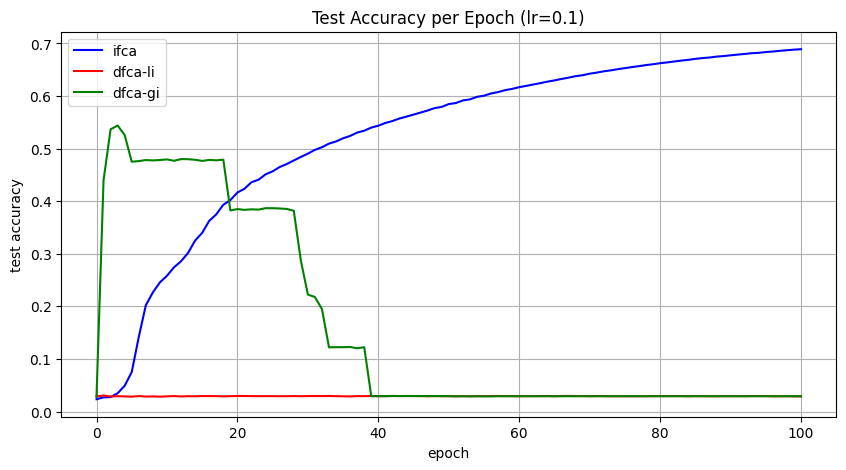

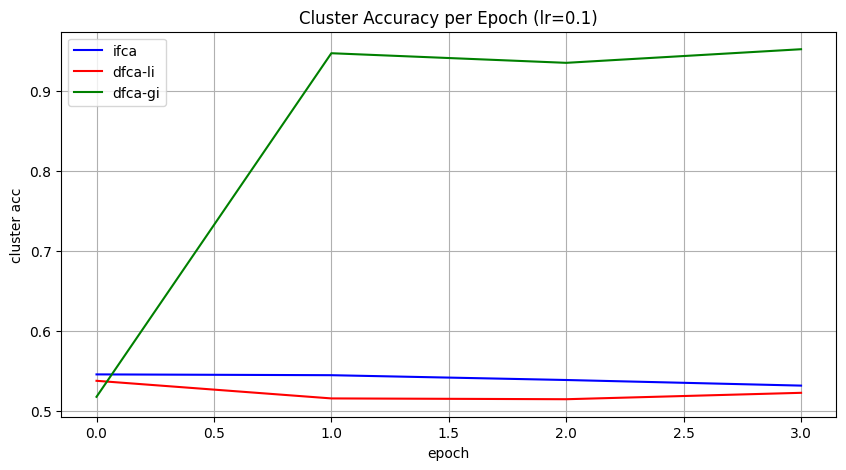

In [9]:

r_ifca = {}
r_dfca_gi = {}
r_dfca_li = {}

r_ifca['test_loss'] = []
r_ifca['test_acc'] = []
r_ifca['cl_acc'] = []
for i in range(len(learning_rates)):
    r_ifca['test_loss'].append(ifca[i][0])
    r_ifca['test_acc'].append(ifca[i][1])
    r_ifca['cl_acc'].append(ifca[i][2])

r_dfca_gi['test_loss'] = []
r_dfca_gi['test_acc'] = []
r_dfca_gi['cl_acc'] = []
for i in range(len(learning_rates)):
    r_dfca_gi['test_loss'].append(dfca_gi[i][0])
    r_dfca_gi['test_acc'].append(dfca_gi[i][1])
    r_dfca_gi['cl_acc'].append(dfca_gi[i][2])

r_dfca_li['test_loss'] = []
r_dfca_li['test_acc'] = []
r_dfca_li['cl_acc'] = []
for i in range(len(learning_rates)):
    r_dfca_li['test_loss'].append(dfca_li[i][0])
    r_dfca_li['test_acc'].append(dfca_li[i][1])
    r_dfca_li['cl_acc'].append(dfca_li[i][2])

print(r_ifca)

os.makedirs('graphs', exist_ok=True)

for l in range(len(learning_rates)):

    plt.figure(figsize=(10,5))
    plt.plot(r_ifca['test_loss'][l], label='ifca', color='blue')
    plt.plot(r_dfca_li['test_loss'][l], label='dfca-li', color='red')
    plt.plot(r_dfca_gi['test_loss'][l], label='dfca-gi', color='green')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title(f'Test Loss per Epoch (lr={learning_rates[l]})')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join('graphs', 'train_loss.png'))

    plt.figure(figsize=(10,5))
    plt.plot(r_ifca['test_acc'][l], label='ifca', color='blue')
    plt.plot(r_dfca_li['test_acc'][l], label='dfca-li', color='red')
    plt.plot(r_dfca_gi['test_acc'][l], label='dfca-gi', color='green')
    plt.xlabel('epoch')
    plt.ylabel('test accuracy')
    plt.title(f'Test Accuracy per Epoch (lr={learning_rates[l]})')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join('graphs', 'test_acc.png'))

    plt.figure(figsize=(10,5))
    plt.plot(r_ifca['cl_acc'][l][:4], label='ifca', color='blue')
    plt.plot(r_dfca_li['cl_acc'][l][:4], label='dfca-li', color='red')
    plt.plot(r_dfca_gi['cl_acc'][l][:4], label='dfca-gi', color='green')
    plt.xlabel('epoch')
    plt.ylabel('cluster acc')
    plt.title(f'Cluster Accuracy per Epoch (lr={learning_rates[l]})')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join('graphs', 'cluster_acc.png'))